Importing Necessary Libraries

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.fftpack import fft2
tf.__version__
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping




Importing the Dataset

In [43]:
# Load the dataset
image_folder = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_1\Set1\Centre"
csv_file = r"C:\Users\91897\Desktop\CP302\Center Results\Mean_speckle_contrast_values_Center.csv"

# Loading Y(Mean Speckle Contrast) values from CSV
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:92, 4].values.astype(float)  # Taking Mean  column from row 3 to 92 (90 values)
Y = [f"{value:.4f}" for value in Y_values] #Rounding off numbers to 4 decimal points.
print('Mean Speckle Contrast values: ', Y)
print('Number of Mean Speckle contrast values [Y]: ',len(Y))

Mean Speckle Contrast values:  ['0.4965', '0.4919', '0.5042', '0.5009', '0.5315', '0.4738', '0.4847', '0.4692', '0.4959', '0.5138', '0.5613', '0.5041', '0.4812', '0.5241', '0.4831', '0.5119', '0.4911', '0.5579', '0.5055', '0.4866', '0.5636', '0.6120', '0.5608', '0.5212', '0.5365', '0.5665', '0.6072', '0.5531', '0.5448', '0.5182', '0.6090', '0.5202', '0.4864', '0.4963', '0.5259', '0.4912', '0.5052', '0.4589', '0.5416', '0.4742', '0.5021', '0.5224', '0.5877', '0.5202', '0.5017', '0.4874', '0.4514', '0.5037', '0.4743', '0.5070', '0.4678', '0.4966', '0.4807', '0.4528', '0.6209', '0.5494', '0.6117', '0.5022', '0.4401', '0.4931', '0.4666', '0.5040', '0.5204', '0.4799', '0.4876', '0.4821', '0.5098', '0.4856', '0.5016', '0.4663', '0.4786', '0.4465', '0.4340', '0.4474', '0.4699', '0.4536', '0.4895', '0.5899', '0.5396', '0.4886', '0.4721', '0.4673', '0.4910', '0.5162', '0.4459', '0.5067', '0.4663', '0.4701', '0.4537', '0.4603', '0.5047']
Number of Mean Speckle contrast values [Y]:  91


Image Preprocessing and FFT

In [44]:
# Function to apply FFT and return magnitude spectrum
def apply_fourier_transform(image):
    f = np.fft.fft2(image)  # Compute the 2D FFT
    fshift = np.fft.fftshift(f)  # Shift zero frequency components to the center
    magnitude_spectrum = np.abs(fshift)  # Get the magnitude
    return magnitude_spectrum

# Prepare input data X
X_values = []  # Arrays storing spatial data for each speckle image sample
resize = (909, 689)  # Define the desired size for all images (change as needed)

# Loop through the images in the specified folder
for image_file in sorted(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    
    if img is not None:
        img_resized = cv2.resize(img, resize)
        img_fft = apply_fourier_transform(img_resized)  # Apply FFT
        X_values.append(img_fft.flatten())  # Flatten the FFT result and store it
    
# Convert to NumPy array
X_values = np.array(X_values,dtype=np.float32)
print('Spatial domain frequency data for speckle images: ', X_values)
print('Shape of input data X:', X_values.shape)
print('No of Image samples fed:',len(X_values))

# Ensure that X and Y have compatible shapes
if len(X_values) != len(Y_values):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')              

Spatial domain frequency data for speckle images:  [[1070.734  873.207 1579.366 ... 1579.366  873.207 1070.734]
 [2450.612 2446.77  2622.101 ... 2622.101 2446.77  2450.612]
 [ 671.894 4455.588 2639.818 ... 2639.818 4455.588  671.894]
 ...
 [3375.195 3364.846 3864.741 ... 3864.741 3364.846 3375.195]
 [5102.047 2461.21  2056.797 ... 2056.797 2461.21  5102.047]
 [1306.027 4138.406 5247.513 ... 5247.513 4138.406 1306.027]]
Shape of input data X: (91, 626301)
No of Image samples fed: 91
Compatible shapes and X and Y are matched


Motion Information

In [45]:
# Initialize an empty list to store motion information features
motion_info = []

# Calculate motion features for each image frame
for i in range(1, len(X_values)):
    # Compute the difference between successive frames
    diff = X_values[i] - X_values[i - 1]
    
    # Calculate motion features
    mean_change = np.mean(np.abs(diff))  # Mean absolute change
    std_change = np.std(diff)  # Standard deviation of the change
    max_change = np.max(np.abs(diff))  # Maximum absolute change
    energy_change = np.sum(diff**2)  # Energy of the change

    # Append the features to the motion_info list
    motion_info.append([mean_change, std_change, max_change, energy_change])

# Convert the motion information to a NumPy array
motion_info = np.array(motion_info)

# Since the first image does not have a preceding frame to compare, we can append zeros or mean values
# Append a row of zeros for the first frame
motion_info = np.vstack(([0, 0, 0, 0], motion_info))

# Display the shape and content of the motion information
print('Shape of Motion Information:', motion_info.shape)
print('Motion Information Features:', motion_info)

Shape of Motion Information: (91, 4)
Motion Information Features: [[0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [5.931e+03 1.558e+04 1.609e+06 1.522e+14]
 [5.295e+03 1.292e+04 1.958e+06 1.046e+14]
 [5.197e+03 1.213e+04 1.203e+06 9.221e+13]
 [5.226e+03 1.198e+04 6.020e+05 8.982e+13]
 [5.350e+03 1.260e+04 1.125e+06 9.954e+13]
 [5.297e+03 1.282e+04 2.365e+06 1.031e+14]
 [5.204e+03 1.207e+04 1.119e+06 9.134e+13]
 [5.257e+03 1.216e+04 7.193e+05 9.256e+13]
 [5.298e+03 1.225e+04 7.306e+05 9.403e+13]
 [5.260e+03 1.179e+04 5.067e+05 8.705e+13]
 [5.884e+03 1.303e+04 1.272e+06 1.076e+14]
 [5.901e+03 1.322e+04 1.025e+06 1.109e+14]
 [5.228e+03 1.190e+04 5.554e+05 8.874e+13]
 [5.203e+03 1.230e+04 8.344e+05 9.474e+13]
 [5.219e+03 1.271e+04 1.350e+06 1.013e+14]
 [5.297e+03 1.202e+04 5.957e+05 9.048e+13]
 [5.302e+03 1.220e+04 7.741e+05 9.321e+13]
 [5.369e+03 1.311e+04 1.821e+06 1.076e+14]
 [5.414e+03 1.279e+04 9.574e+05 1.024e+14]
 [5.314e+03 1.244e+04 6.197e+05 9.694e+13]
 [5.355e+03 1.239e+04 8.741e+05

Data preprocessing

In [46]:
# Convert Y from a list of strings to a NumPy array of floats
Y = np.array(Y_values, dtype=np.float32)

# Ensure that X and Y have compatible shapes
if len(motion_info) != len(Y):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(motion_info)


# Splitting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)

print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_test:',y_test.shape)



Compatible shapes and X and Y are matched
Shape of X_train: (63, 4)
Shape of y_train: (63,)
Shape of X_test: (28, 4)
Shape of y_test: (28,)


Data preprocessing for Active motion data

In [6]:
# Convert Y from a list of strings to a NumPy array of floats
Y = np.array(Y_values, dtype=np.float32)

# Ensure that X and Y have compatible shapes
if len(X_values) != len(Y):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes and X and Y are matched')

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

from sklearn.decomposition import PCA
pca = PCA(n_components=50) #reduces the features from 626301 to 50 by projecting them into new lower dimensional space
X_pca = pca.fit_transform(X_scaled)
print("Shape of X after PCA:", X_pca.shape)

# Splitting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)



Compatible shapes and X and Y are matched
Shape of X after PCA: (91, 50)
(72, 50)
(72,)


ANN with Hyperparameter tuning with GridsearchCV

In [47]:
# Define the ANN model
def create_model(dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))  # Change as per your input shape
    model.add(Dropout(rate=dropout_rate)) 
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='linear'))  # Assuming regression task
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrapping the model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0,dropout_rate=0.0)

# Hyperparameter grid for tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.0, 0.2, 0.4],
    'epochs': [50,100],
    'batch_size': [16, 32]
}

In [49]:
from keras.layers import Dense, Dropout
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3,n_jobs=-1)
grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping], validation_split=0.2)

# Best model from Grid Search
best_model = grid_result.best_estimator_

C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimal hyperparameters

In [51]:
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 100, 'optimizer': 'adam'}


Predictions on the Test set

In [52]:
y_pred = best_model.predict(X_test)
np.set_printoptions(precision=3)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0.447 0.502]
 [0.582 0.561]
 [0.48  0.549]
 [0.577 0.454]
 [1.917 0.497]
 [0.501 0.607]
 [0.494 0.474]
 [0.519 0.51 ]
 [0.518 0.561]
 [0.493 0.502]
 [0.468 0.507]
 [0.47  0.491]
 [0.483 0.479]
 [0.455 0.52 ]
 [0.537 0.481]
 [0.489 0.531]
 [0.497 0.505]
 [0.477 0.545]
 [0.489 0.507]
 [0.462 0.488]
 [0.474 0.512]
 [0.508 0.486]
 [0.478 0.59 ]
 [0.507 0.609]
 [0.53  0.496]
 [0.567 0.504]
 [0.489 0.482]
 [0.481 0.502]]


Performance metrics

In [53]:
from sklearn.metrics import mean_absolute_error
print('R2-score (test set): {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE(test set): ',mean_squared_error(y_test,y_pred))
print('MAE(test set): ',mean_absolute_error(y_test,y_pred))

R2-score (test set): -48.765
MSE(test set):  0.07512279
MAE(test set):  0.09371865


Plotting results

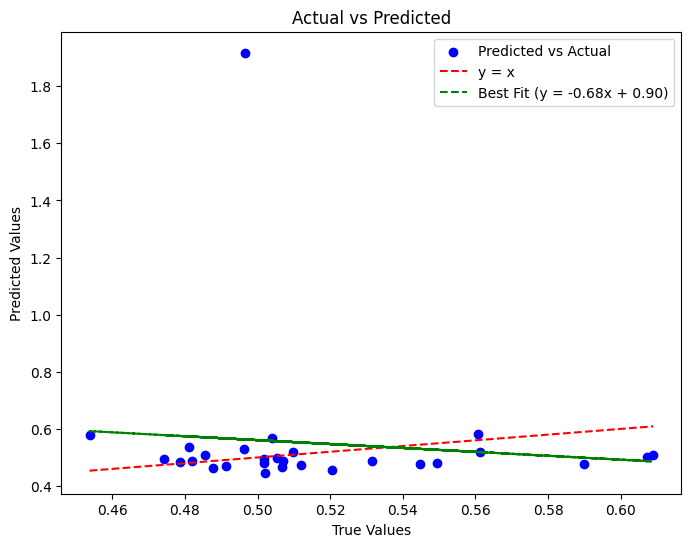

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Predicted vs Actual',color = 'blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y = x') #y=x line

# Best-fit line according to the plots(Regression)
slope, intercept = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)
best_fit_line = slope * y_test + intercept

plt.plot(y_test, best_fit_line, 'g--', label=f'Best Fit (y = {slope:.2f}x + {intercept:.2f})')
plt.xlabel('True Values')
#plt.ylim(0.4,0.8)
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

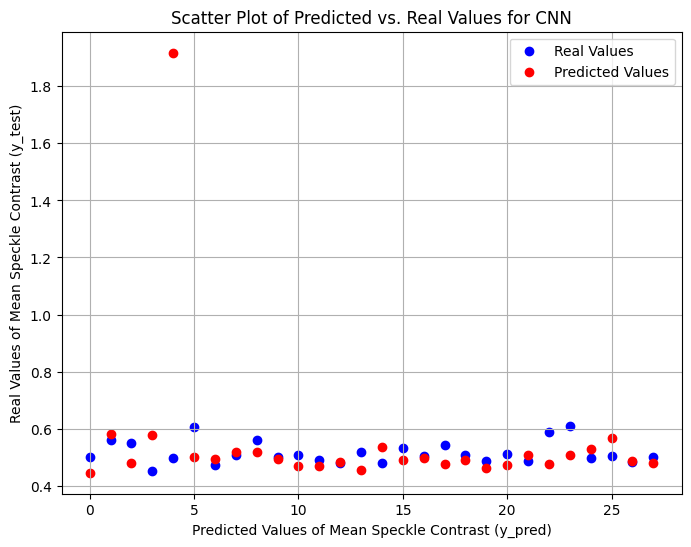

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Real Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values')
plt.title('Scatter Plot of Predicted vs. Real Values for CNN')
plt.ylabel('Real Values of Mean Speckle Contrast (y_test)')
plt.xlabel('Predicted Values of Mean Speckle Contrast (y_pred)')
plt.legend()
plt.grid(True)
plt.show()

PCA for dimensionality reduction

ANN training after PCA

In [7]:

def create_model(neurons=128, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Regression output layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Wrap the model for scikit-learn's GridSearchCV
model = KerasRegressor(model=create_model, verbose=0,dropout_rate=0.2,learning_rate=0.001,neurons=64)

Hypertuning with GridsearchCV

In [8]:
# Define the grid of hyperparameters to search
param_grid = {
    'neurons': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}
# Apply GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train, y_train)

# Summarize the results of the grid search
print(f"Best score: {grid_result.best_score_}")
print(f"Best params: {grid_result.best_params_}")


C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

Best score: -0.15047730257113776
Best params: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.01, 'neurons': 256}


Model evaluation

In [25]:
# Get the best parameters from grid search
best_params = grid_result.best_params_

# Create and train the model again with the best parameters and store the history
best_model = create_model(neurons=best_params['neurons'], 
                          dropout_rate=best_params['dropout_rate'], 
                          learning_rate=best_params['learning_rate'])

# Train the best model on the training data, and capture the history for plotting
history = best_model.fit(X_train, y_train, validation_split=0.2, 
                         epochs=best_params['epochs'], 
                         batch_size=best_params['batch_size'], 
                         verbose=0)
# Evaluate on test data with the best model
#best_model = grid_result.best_estimator_.model_
y_pred = best_model.predict(X_test)
np.set_printoptions(precision=4)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[ 0.3887  0.5021]
 [ 0.0347  0.5608]
 [ 0.0347  0.5494]
 [ 0.6275  0.4537]
 [ 0.662   0.4965]
 [ 0.4118  0.6072]
 [ 0.0347  0.4742]
 [ 0.2403  0.5098]
 [ 0.0347  0.5613]
 [ 0.0347  0.5017]
 [-0.4804  0.5067]
 [ 0.0347  0.4912]
 [ 0.403   0.4786]
 [ 0.0347  0.5204]
 [ 0.318   0.4812]
 [ 0.7637  0.5315]
 [ 0.0347  0.5055]
 [ 0.2682  0.5448]
 [ 0.4495  0.507 ]]


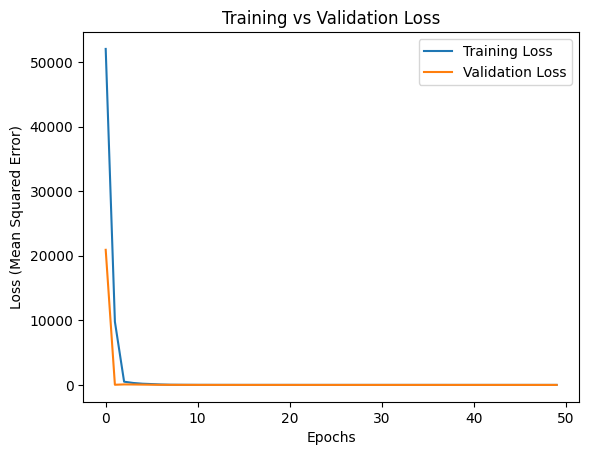

In [26]:
# Plotting Training Loss vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

Performance metrics

In [27]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Test R^2 score: {r2}")
print(f"Test MSE: {mse}")

Test R^2 score: -130.32443237304688
Test MSE: 0.16936729848384857


Scatter Plot of results

C:\Users\91897\AppData\Local\Temp\ipykernel_9116\3556798838.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


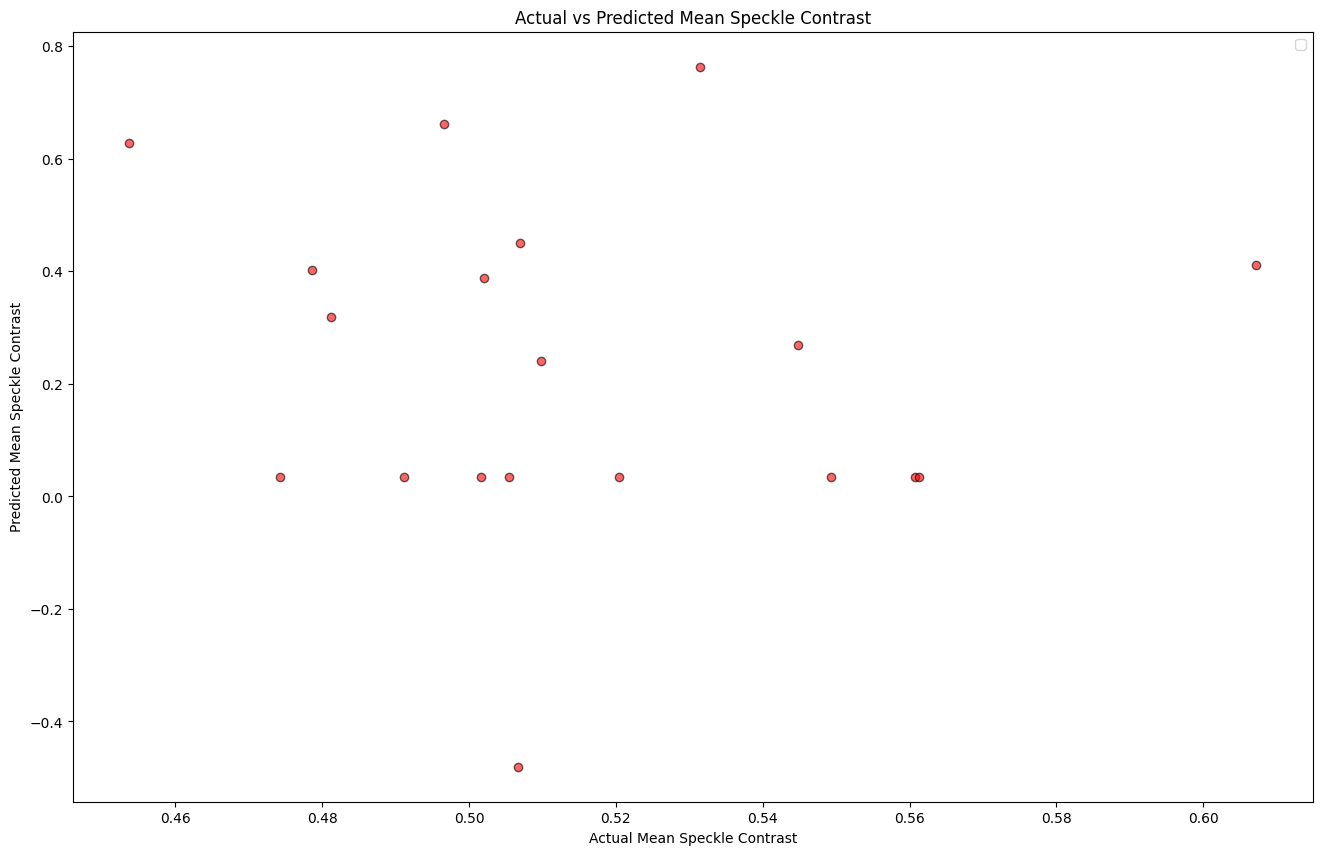

In [28]:
plt.figure(figsize=(16,10))
plt.scatter( y_test, y_pred, c = 'red'  ,edgecolors='black', alpha=0.6)
plt.xlabel('Actual Mean Speckle Contrast')
plt.ylabel('Predicted Mean Speckle Contrast')
plt.title('Actual vs Predicted Mean Speckle Contrast')
plt.legend()

ANN without gridsearch cv

In [41]:
# Updated model architecture
ann = tf.keras.models.Sequential()

# Reduce the number of units
input_shape = X_train.shape[1]  # Input shape based on your flattened FFT image data
ann.add(tf.keras.layers.Dense(units=1024, activation='relu', input_shape=(input_shape,)))
ann.add(tf.keras.layers.Dense(units=512, activation='relu'))
#ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Output layer (for regression)
ann.add(tf.keras.layers.Dense(units=1))

# Compile the model
ann.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = ann.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, verbose=1)


Epoch 1/50


C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 1325.1451 - val_loss: 617.1852
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2533.7349 - val_loss: 619.6246
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1693.2816 - val_loss: 749.9075
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1277.9573 - val_loss: 390.7827
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 391.8789 - val_loss: 63.9893
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 406.6796 - val_loss: 287.2634
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 523.0091 - val_loss: 105.7822
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 220.0531 - val_loss: 30.2752
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 155.2906 - val_loss: 94.7311
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 219.7934 - val_loss: 65.0281
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 125.2308 - val_loss: 14.6498
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - 

Predictions on Test set

In [42]:
# Predictions and performance metrics on the test set
y_pred = ann.predict(X_test)
np.set_printoptions(precision=4)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Test R^2 score: {r2}")
print(f"Test MSE: {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[[ -3.9679   0.5021]
 [ -5.6992   0.5608]
 [  6.2633   0.5494]
 [ -2.3317   0.4537]
 [-11.1838   0.4965]
 [ -1.9933   0.6072]
 [-11.9865   0.4742]
 [ -1.3712   0.5098]
 [ -1.682    0.5613]
 [ -3.6248   0.5017]
 [ -3.3183   0.5067]
 [  0.6449   0.4912]
 [ -3.4724   0.4786]
 [ -1.6439   0.5204]
 [  1.3641   0.4812]
 [ -4.3544   0.5315]
 [  4.5288   0.5055]
 [  8.6203   0.5448]
 [  1.9429   0.507 ]]
Test R^2 score: -23125.833984375
Test MSE: 29.82635498046875
